# Import libraries

In [11]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import re
import seaborn as sns
import matplotlib.pyplot as plt
from scripts.helpers import map_to_color

# Load data

In [2]:
from scripts.parse_vars import parse_variables, load_config
PATH_VARS = Path("../../geno_simulation.txt")
# Random seed for reproducibility of the flip step
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)
cfg = load_config(PATH_VARS)
G = int(cfg["G"]); L = int(cfg["L"]); c = int(cfg["c"]); k = int(cfg["k"]); M = float(cfg["M"]);
# Build prefix pattern for filtering
prefix = f"G{G}_L{L}_c{c}_k{k}_M{M}"

# Filter only relevant directories
filtered = [d for d in os.listdir("simulation_data") if d.startswith(prefix)]
# Extract F values and mixed cases
F_values = []
mixed_cases = []

for d in filtered:
    # Check if F is present
    match_F = re.search(r"F([0-9.]+)", d)
    if match_F:
        F_values.append(float(match_F.group(1)))

    # Check if mixed is present
    match_mixed = re.search(r"(mixed_[^/]+)", d)
    if match_mixed:
        mixed_cases.append(match_mixed.group(1))
#base_path = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F_values[0]}/genotype"
base_path = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_{mixed_cases[0]}"
path_geno = f"{base_path}/genotype"
geno = pd.read_pickle((f"{path_geno}/complete.pkl"))

In [3]:
path_pcs = f"{base_path}/PCs"

In [4]:
het = (geno == 0).astype(int)

In [6]:
import os, re

pc_files = [f for f in os.listdir(path_pcs) if re.match(r"^geno_\d", f)]
pc_files = sorted(pc_files, key=lambda x: int(re.search(r'geno_(\d+)_PCs', x).group(1)))
path_pheno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_{mixed_cases[0]}/phenotype/"
humans= pd.read_pickle(f"{path_pheno}/humans.pkl")


for pc_file in pc_files:
    nr_pcs = int(pc_file.split("_")[1])
    path_pc = f"{path_pcs}/{pc_file}"
    PCs = pd.read_pickle(path_pc)
    common_idx = PCs.index.intersection(geno.index)
    PCs = PCs.loc[common_idx]
    geno = geno.loc[common_idx]
    het = (geno == 0).astype(int)
    pc_means = PCs.mean(axis=0)
    PCs_c = PCs - pc_means  # (n, k)
    n = PCs_c.shape[0]
    X = np.column_stack([np.ones(n), PCs_c.values])   # (n, 1+k)
    
    B, residuals, rank, s = np.linalg.lstsq(X, geno.values, rcond=None)
    
    # 4) Extract M_mean (length = n_snps) and weights
    M_mean = pd.Series(B[0, :], index=geno.columns, name="maf_mean") 
    W = pd.DataFrame(B[1:, :], index=PCs.columns, columns=geno.columns) 
    
    # 5) Reconstruct genotypes for the observed samples
    #    M_hat = 1·M_mean^T + PCs_c · W
    mu_hat  = X @ B
    mu_hat  = pd.DataFrame(mu_hat , index=geno.index, columns=geno.columns)
    p_hat  = np.clip((mu_hat + 1.0) / 2.0, 1e-6, 1 - 1e-6)

    n = PCs_c.shape[0]
    X = np.column_stack([np.ones(n), PCs_c.values])   # (n, 1+k)
    
    B, residuals, rank, s = np.linalg.lstsq(X, het.values, rcond=None)
    
    # 4) Extract M_mean (length = n_snps) and weights
    het_mean = pd.Series(B[0, :], index=het.columns, name="het_mean")
    W = pd.DataFrame(B[1:, :], index=PCs.columns, columns=het.columns) 
    
    # 5) Reconstruct genotypes for the observed samples
    #    M_hat = 1·M_mean^T + PCs_c · W
    het_hat  = X @ B
    het_hat  = pd.DataFrame(het_hat , index=het.index, columns=het.columns)
    het_hat = np.clip(het_hat, 1e-6, 1 - 1e-6)
    
    denom = 2 * p_hat * (1 - p_hat)
    F_hat   = np.clip(1 - het_hat/denom, 0, 1)
    humans[f"estimated_inbreeding_{nr_pcs}_PCs"] = F_hat.mean(axis=1)

In [7]:
humans

,populations,x,y,mix,breed,estimated_inbreeding_1_PCs,estimated_inbreeding_5_PCs,estimated_inbreeding_15_PCs,estimated_inbreeding_35_PCs,estimated_inbreeding_40_PCs,estimated_inbreeding_50_PCs,estimated_inbreeding_100_PCs
0,1,1,1,0.0,outbred,0.427266,0.281340,0.338377,0.241031,0.239271,0.272902,0.232070
1,1,1,1,0.0,outbred,0.442672,0.286033,0.333360,0.278402,0.294000,0.300104,0.326364
2,1,1,1,0.0,outbred,0.413802,0.270150,0.321253,0.223935,0.222943,0.281626,0.287865
3,1,1,1,0.0,outbred,0.438470,0.290527,0.330516,0.234924,0.230885,0.245419,0.253428
4,1,1,1,0.0,outbred,0.422402,0.262034,0.323026,0.211723,0.215670,0.237522,0.226471
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,100,10,10,1.0,inbred,0.861489,0.732130,0.558823,0.565607,0.554578,0.569872,0.539441
1996,100,10,10,1.0,inbred,0.850807,0.717570,0.665895,0.664828,0.693486,0.698643,0.615420
1997,100,10,10,1.0,inbred,0.850864,0.707802,0.598853,0.569196,0.554314,0.557568,0.597586
1998,100,10,10,1.0,inbred,0.857482,0.721659,0.601088,0.640191,0.620914,0.614308,0.604380


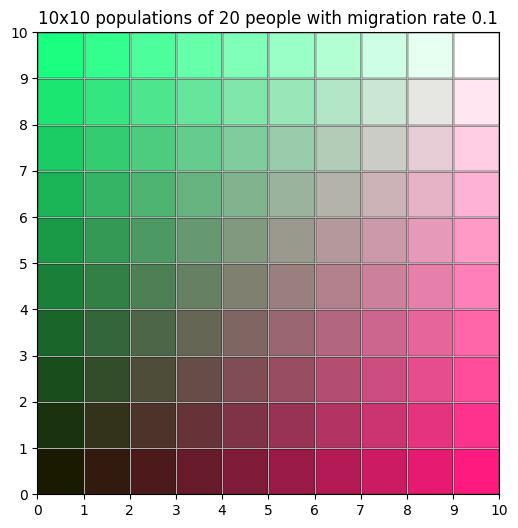

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))

for i in range(k):
    for j in range(k):
        # pick the row for this grid cell
        row = humans[(humans['x'] == i+1) & (humans['y'] == j+1)].iloc[0]
        # compute ONE color for this cell
        cell_color = map_to_color(row['x'], row['y'], row['mix'], humans, 'mix')

        ax.add_patch(plt.Rectangle((i, j), 1, 1, facecolor=cell_color, edgecolor='black'))

ax.set_xlim(0, k)
ax.set_ylim(0, k)
ax.set_aspect('equal')
ax.set_xticks(range(k + 1))
ax.set_yticks(range(k + 1))
ax.grid(True)
plt.title(f"{k}x{k} populations of {c} people with migration rate {M}")
plt.show()

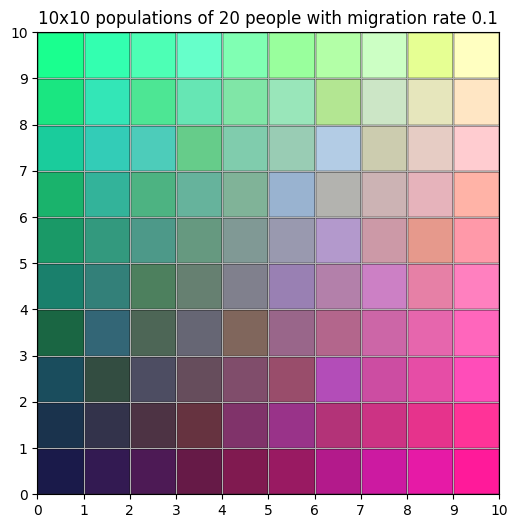

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))

for i in range(k):
    for j in range(k):
        # pick the row for this grid cell
        row = humans[(humans['x'] == i+1) & (humans['y'] == j+1)].iloc[0]
        # compute ONE color for this cell
        cell_color = map_to_color(row['x'], row['y'], row['estimated_inbreeding_100_PCs'], humans, 'estimated_inbreeding_100_PCs')

        ax.add_patch(plt.Rectangle((i, j), 1, 1, facecolor=cell_color, edgecolor='black'))

ax.set_xlim(0, k)
ax.set_ylim(0, k)
ax.set_aspect('equal')
ax.set_xticks(range(k + 1))
ax.set_yticks(range(k + 1))
ax.grid(True)
plt.title(f"{k}x{k} populations of {c} people with migration rate {M}")
plt.show()

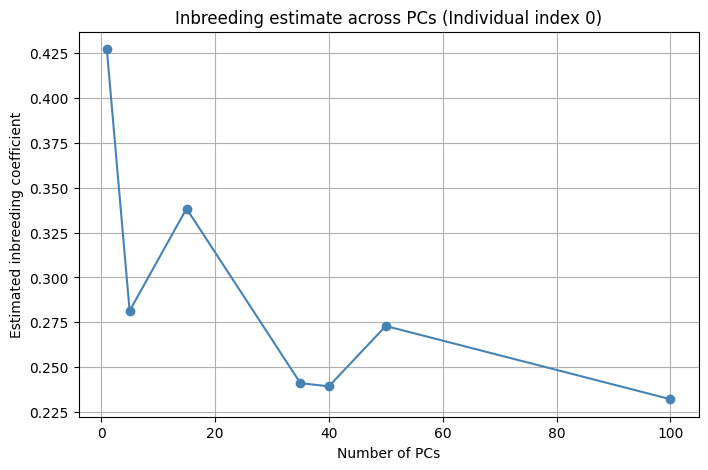

In [16]:

# Suppose we take the first row (index 0, one individual)
row = humans.iloc[0]

# Extract PC numbers from column names
pc_labels = [int(col.split("_")[2]) for col in humans.columns if "estimated_inbreeding" in col]
# Extract the corresponding values for this row
inbreeding_values = [row[col] for col in humans.columns if "estimated_inbreeding" in col]

# Plot
plt.figure(figsize=(8,5))
plt.plot(pc_labels, inbreeding_values, marker="o", linestyle="-", color="steelblue")
plt.xlabel("Number of PCs")
plt.ylabel("Estimated inbreeding coefficient")
plt.title(f"Inbreeding estimate across PCs (Individual index {row.name})")
plt.grid(True)
plt.show()

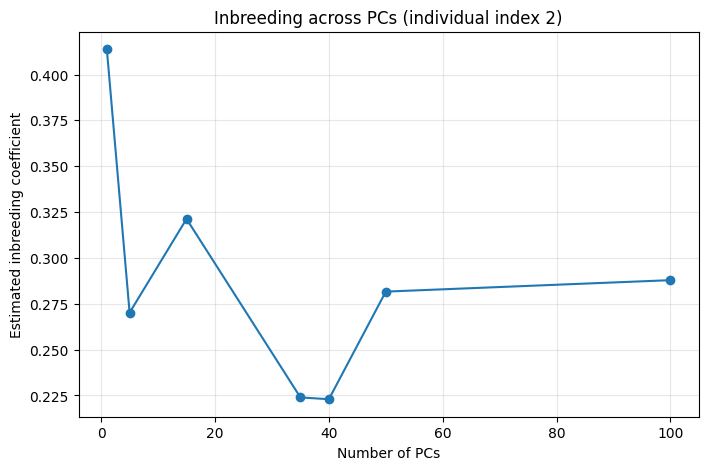

In [19]:
import re
import matplotlib.pyplot as plt

# kies 1 individu
row = humans.iloc[2]

# vind en sorteer de PC-kolommen op het numerieke PC-nummer
pc_cols = [c for c in humans.columns if c.startswith("estimated_inbreeding_")]
pc_pairs = [(int(re.search(r"estimated_inbreeding_(\d+)_PCs", c).group(1)), c) for c in pc_cols]
pc_pairs.sort(key=lambda x: x[0])
pc_labels = [k for k, _ in pc_pairs]
inbreeding_values = [row[c] for _, c in pc_pairs]

plt.figure(figsize=(8,5))
plt.plot(pc_labels, inbreeding_values, marker="o")
plt.xlabel("Number of PCs")
plt.ylabel("Estimated inbreeding coefficient")
plt.title(f"Inbreeding across PCs (individual index {row.name})")
plt.grid(True, alpha=0.3)
plt.show()


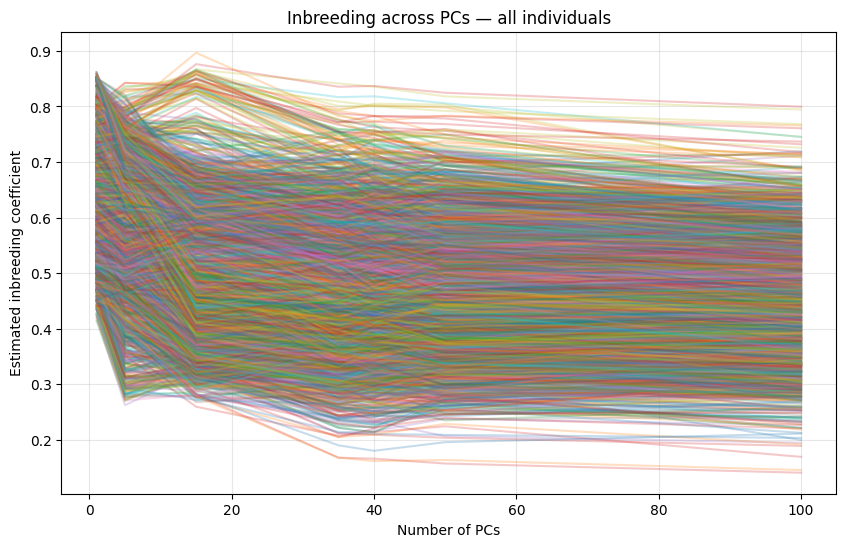

In [20]:
plt.figure(figsize=(10,6))
for _, r in humans.iterrows():
    plt.plot(pc_labels, r[[c for _, c in pc_pairs]].values, alpha=0.25)
plt.xlabel("Number of PCs")
plt.ylabel("Estimated inbreeding coefficient")
plt.title("Inbreeding across PCs — all individuals")
plt.grid(True, alpha=0.3)
plt.show()


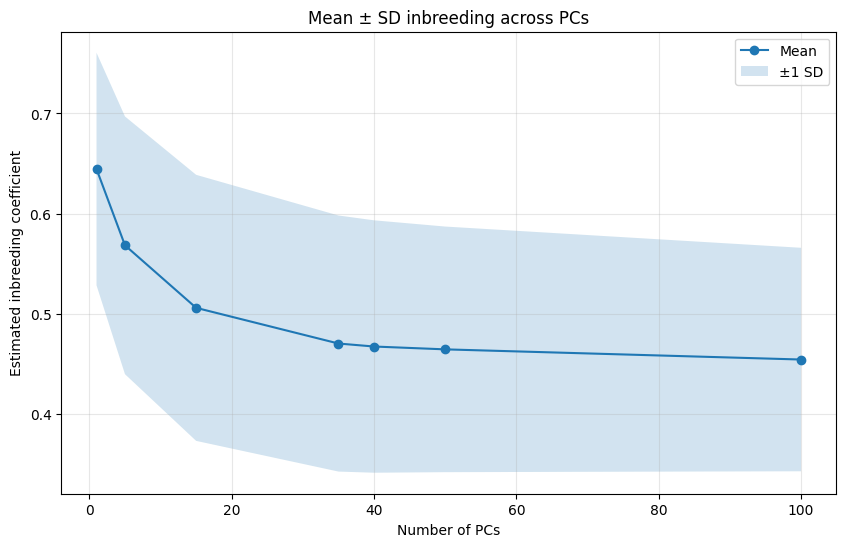

In [21]:
import numpy as np

vals = humans[[c for _, c in pc_pairs]]
means = vals.mean(axis=0).values
stds  = vals.std(axis=0).values

plt.figure(figsize=(10,6))
plt.plot(pc_labels, means, marker="o", label="Mean")
plt.fill_between(pc_labels, means - stds, means + stds, alpha=0.2, label="±1 SD")
plt.xlabel("Number of PCs")
plt.ylabel("Estimated inbreeding coefficient")
plt.title("Mean ± SD inbreeding across PCs")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


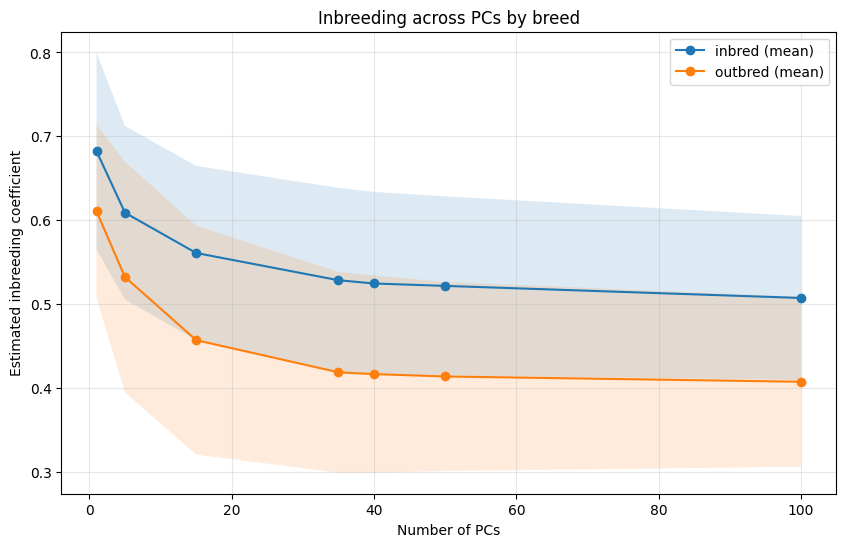

In [22]:
plt.figure(figsize=(10,6))

for grp, gdf in humans.groupby("breed"):
    gvals = gdf[[c for _, c in pc_pairs]]
    gmean = gvals.mean(axis=0).values
    gsd   = gvals.std(axis=0).values
    plt.plot(pc_labels, gmean, marker="o", label=f"{grp} (mean)")
    plt.fill_between(pc_labels, gmean - gsd, gmean + gsd, alpha=0.15)

plt.xlabel("Number of PCs")
plt.ylabel("Estimated inbreeding coefficient")
plt.title("Inbreeding across PCs by breed")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
